#  Air Quality: Design Phase

1. Import Python packages
2. Load the data
3. Add location (latitude and longitude of sensor stations) to the dataframe
4. Visualize the extent and distribution of missing data
5. Visualize simple methods for estimating missing values
6. Run the nearest neighbor method to establish a baseline
7. Prepare the data to train a neural network model
8. Train and test a neural network model for estimating missing values
9. Visualize the results from your baseline model compared to the neural network
10. Estimate missing sensor measurements across all pollutants 
11. Visualize the results of filling in missing PM2.5 values

## 1. Import Python packages

In [1]:
import pandas as pd
from datetime import datetime 
from sklearn.model_selection import train_test_split

import utils_design 

print('All packages imported successfully!')

All packages imported successfully!


## 2. Load the data

In [2]:
# Read in the data
raw_data = pd.read_csv('data/RMCAB_air_quality_sensor_data.csv')
# Modify the DateTime column format
raw_data['DateTime'] = pd.to_datetime(utils_design.fix_dates(raw_data, 'DateTime'), dayfirst=True)
# Rename columns from Spanish to English
raw_data = raw_data.rename(columns={'OZONO': 'OZONE'})
# print out the number of rows in the dataframe
print(f"The dataset contains {len(raw_data)} entries")
# Print out the first few lines in the dataframe
raw_data.head(5)

The dataset contains 166440 entries


,PM10,PM2.5,NO,NO2,NOX,CO,OZONE,Station,DateTime
0,56.6,32.7,7.504,15.962,23.493,0.44924,2.431,USM,2021-01-01 00:00:00
1,59.3,39.3,16.560,17.866,34.426,0.69832,1.121,USM,2021-01-01 01:00:00
2,96.4,70.8,22.989,17.802,40.791,0.88243,1.172,USM,2021-01-01 02:00:00
3,108.3,81.0,3.704,9.886,13.591,0.29549,6.565,USM,2021-01-01 03:00:00
4,87.7,56.1,2.098,9.272,11.371,0.16621,9.513,USM,2021-01-01 04:00:00


## 3. Add location (latitude and longitude of sensor stations) to the dataframe

In [3]:
# Read in csv file containing location data and format appropriately
stations = pd.read_csv('data/stations_loc.csv')
stations = stations[['Sigla', 'Latitud', 'Longitud']]
# Rename the columns from Spanish to English
stations = stations.rename(columns={'Sigla': 'Station', 'Latitud': 'Latitude', 'Longitud': 'Longitude'})
# Parse the dates
stations['Latitude'] = stations['Latitude'].apply(utils_design.parse_dms)
stations['Longitude'] = stations['Longitude'].apply(utils_design.parse_dms)
# Add location data as extra columns to air pollution dataset
raw_data_enriched = pd.merge(raw_data, stations, on='Station', how='inner')
raw_data_enriched.head(5)

,PM10,PM2.5,NO,NO2,NOX,CO,OZONE,Station,DateTime,Latitude,Longitude
0,56.6,32.7,7.504,15.962,23.493,0.44924,2.431,USM,2021-01-01 00:00:00,4.532056,-74.117139
1,59.3,39.3,16.560,17.866,34.426,0.69832,1.121,USM,2021-01-01 01:00:00,4.532056,-74.117139
2,96.4,70.8,22.989,17.802,40.791,0.88243,1.172,USM,2021-01-01 02:00:00,4.532056,-74.117139
3,108.3,81.0,3.704,9.886,13.591,0.29549,6.565,USM,2021-01-01 03:00:00,4.532056,-74.117139
4,87.7,56.1,2.098,9.272,11.371,0.16621,9.513,USM,2021-01-01 04:00:00,4.532056,-74.117139


## 4. Visualize the extent and distribution of missing data

### 4.1 Count null values

In [4]:
# Print out a count of missing data for each column in the dataset
raw_data_enriched.isnull().sum()

PM10         20014
PM2.5        15312
NO           27664
NO2          27662
NOX          27668
CO           31238
OZONE        32132
Station          0
DateTime         0
Latitude         0
Longitude        0
dtype: int64

### 4.2 Visualize missing data in a time series

In [5]:
# Plot a time series for a particular date range, pollutant, and sensor station
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 1, 31)
utils_design.create_time_series_plot(raw_data, start_date, end_date)

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

### 4.3 Visualize the distribution of gaps in the data

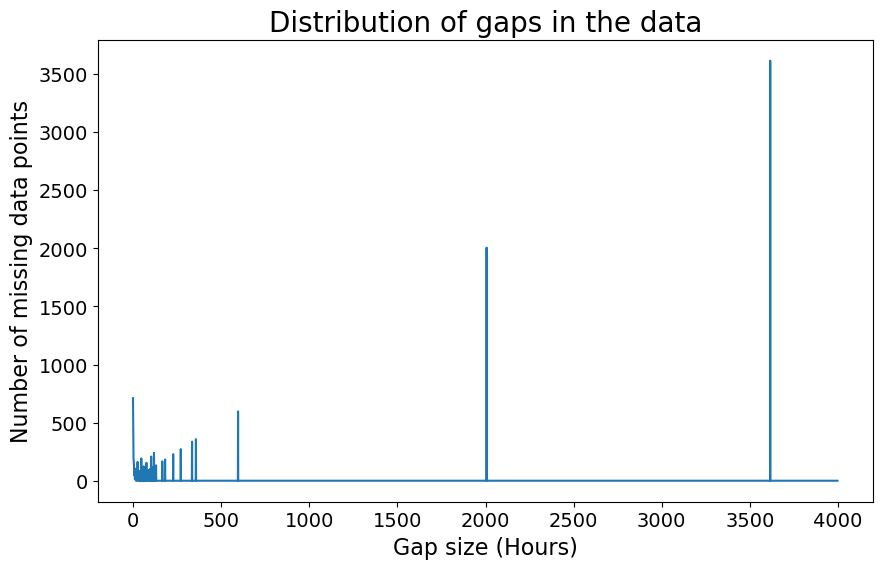

In [6]:
# Plot the distribution of gap sizes in the data
utils_design.plot_distribution_of_gaps(raw_data, target='PM2.5')

## 5. Visualize simple methods for estimating missing values

In [7]:
# Specify the date to plot
day = datetime(2021, 5, 6)

# Create a plot to display the linear interpolation for a range of hours
utils_design.visualize_missing_values_estimation(raw_data_enriched, day);

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

## 6. Run the nearest neighbor method to establish a baseline

$$MAE = \frac{1}{n} \sum_{i=1}^{n}{|\rm{actual}_i - \rm{model}_i|}$$
    
Where "n" is the number of samples in the test dataset

In [8]:
# Create a nearest neighbor model and run it on your test data
regression_scores = {}
regression_scores['baseline_model'] = utils_design.calculate_mae_for_nearest_station(raw_data_enriched, target='PM2.5')
print(regression_scores['baseline_model'])

{'MAE': 8.035857704059362}


## 7. Prepare the data to train a neural network model

### 7.1. Remove missing values and add columns for later use with a neural network model

In [9]:
# Define the variable you want to predict
target = 'PM2.5'

# Create new columns for day of week and hour of day
raw_data_for_imputing = raw_data_enriched.copy()
raw_data_for_imputing['day_week'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).weekday
raw_data_for_imputing['hour'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).hour

# Create a numerical representation of station ID and add as extra columns to the dataframe
one_hot = pd.get_dummies(raw_data_for_imputing.Station, prefix='Station')
raw_data_for_imputing = raw_data_for_imputing.join(one_hot)

# Make a copy of the dataframe before dropping rows with missing values
data_no_missing = raw_data_for_imputing.copy()  
# Drop all rows containing missing values
data_no_missing.dropna(inplace=True)
# Print out the number of missing values in the PM2.5 column as a check (should print 0)
null_remaining = data_no_missing[target].isnull().sum()
if null_remaining == 0: 
    print('missing values removed and data prepared successfully!')

missing values removed and data prepared successfully!


### 7.2 Split data into training and testing sets

In [10]:
train_data, test_data = train_test_split(data_no_missing, test_size=0.20, random_state=57)

print(f'Train dataset size: {train_data.shape}')
print(f'Test dataset size: {test_data.shape}')

Train dataset size: (73309, 32)
Test dataset size: (18328, 32)




    
</details>



## 8. Train and test a neural network model for estimating missing data.

In [11]:
# Define the features you will base your predictions on 
pollutants_list = ['PM10','PM2.5','NO','NO2','NOX','CO','OZONE']
pollutants_except_target = [i for i in pollutants_list if i != target]
feature_names = ['day_week', 'hour'] + list(one_hot.columns) + pollutants_except_target

# Define the neural network model architecture
model = utils_design.build_keras_model(input_size=len(feature_names))

# Train and test the model
model, scaler, mae = utils_design.train_and_test_model(feature_names, target, train_data, test_data, model)
regression_scores['neural_network_model'] = mae

c:\Users\nandi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 2s 786us/step - loss: 46.3265 - mae: 4.8932
Epoch 2/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 35.3426 - mae: 4.3565
Epoch 3/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - loss: 34.1258 - mae: 4.2625
Epoch 4/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - loss: 32.5684 - mae: 4.1893
Epoch 5/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - loss: 32.4964 - mae: 4.1592
Epoch 6/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - loss: 32.1041 - mae: 4.1549
Epoch 7/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - loss: 32.0717 - mae: 4.1421
Epoch 8/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - loss: 31.6719 - mae: 4.1242
Epoch 9/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 31.4788 - mae: 4.1092
Epoch 10/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - loss: 31.0617 - mae: 4.0971
Epoch 11/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 31.9395 - mae: 4.1166
Epoch 12/100
1146/1146 ━━━━━━━━━━━━━━━━━━

Compare the **MAE** obtained using the 2 methods. 

In [12]:
# Print out the MAE result
for model_name, model_score in regression_scores.items():
    print(model_name, ' : ', model_score)

baseline_model  :  {'MAE': 8.035857704059362}
neural_network_model  :  {'MAE': 4.065820031746773}


## 9. Visualize the results from your baseline model compared to the neural network. 

In [13]:
start_date = datetime(2021, 2, 1)
end_date = datetime(2021, 2, 3)

utils_design.create_plot_with_preditions(data_no_missing, model, scaler, feature_names, target,  start_date, end_date)

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

## 10. Estimate missing sensor measurements across all pollutants. 

In [14]:
# Estimate non-PM2.5 missing values with the nearest neighbor method
imputed_with_baseline_model = utils_design.impute_nontarget_missing_values_interpolate(raw_data_for_imputing, feature_names, target)
# Estimate missing PM2.5 values with 
data_with_imputed = utils_design.impute_target_missing_values_neural_network(raw_data_for_imputing, model, scaler, imputed_with_baseline_model, target)
# Print out a count of missing data for each column in the dataset with imputed values
data_with_imputed[pollutants_list].isnull().sum()

479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


PM10     0
PM2.5    0
NO       0
NO2      0
NOX      0
CO       0
OZONE    0
dtype: int64

In [15]:
# Print out a sample of the dataframe
data_with_imputed.sample(25)

,DateTime,Station,Latitude,Longitude,PM2.5,PM10,NO,NO2,NOX,CO,OZONE,PM2.5_imputed_flag,PM10_imputed_flag,NO_imputed_flag,NO2_imputed_flag,NOX_imputed_flag,CO_imputed_flag,OZONE_imputed_flag
4997,2021-07-28 05:00:00,USM,4.532056,-74.117139,3.800000,24.200000,102.655000,22.090000,124.745000,1.241110,0.251500,None,None,None,None,None,None,interpolated
7942,2021-11-27 22:00:00,USM,4.532056,-74.117139,14.300000,57.800000,10.956000,22.509000,33.464000,0.529390,1.562000,None,None,None,None,None,None,None
73358,2021-05-17 14:00:00,CDAR,4.658467,-74.083967,4.000000,9.200000,5.403000,10.842000,16.244000,0.475090,10.864000,None,None,None,None,None,None,None
22921,2021-08-14 01:00:00,SUB,4.761247,-74.093461,13.000000,30.100000,14.160000,14.572000,28.732000,0.433160,0.631000,None,None,None,None,None,None,None
147178,2021-10-20 10:00:00,MOV2,4.668000,-74.148500,28.600000,72.300000,12.231000,17.988000,30.220000,0.537017,21.039000,None,None,None,None,None,interpolated,None
87928,2021-01-14 16:00:00,FTB,4.678242,-74.143819,26.100000,44.300000,6.332663,20.145693,26.456211,0.384420,58.668000,None,None,interpolated,interpolated,interpolated,None,None
6944,2021-10-17 08:00:00,USM,4.532056,-74.117139,8.400000,30.300000,12.005000,15.551000,27.556000,0.430460,8.255000,None,None,None,None,None,None,None
147488,2021-11-02 08:00:00,MOV2,4.668000,-74.148500,16.100000,39.800000,36.784000,23.892000,60.676000,0.539118,8.039000,None,None,None,None,None,interpolated,None
61368,2021-01-03 00:00:00,CBV,4.577806,-74.166278,4.900000,12.700000,0.467000,3.755000,4.221000,0.216300,9.586000,None,None,None,None,None,None,None
49793,2021-09-07 17:00:00,PTE,4.631767,-74.117483,9.900000,35.900000,2.959000,13.278000,16.237000,0.805540,10.672000,None,None,None,None,None,None,None


You can see that the flag columns include different values: `None` where there is original data, `'neural network'` where the values were imputed with the neural network and `'interpolated'` where the values were interpolated.



## 11. Visualize the results of filling in missing PM2.5 values

You can use the flag columns you recorded above to distinguish between original and estimated data, and you can visualize this by running the cell below.

In [ ]:
# Define a start and end date and visualize missing values that have been imputed
start_date = datetime(2021, 3, 1)
end_date = datetime(2021, 4, 30)
utils.create_time_series_plot(data_with_imputed, start_date, end_date)

## 12. Optional: write the resulting dataset to a new csv file

Finally, you can save the data to a new csv file for use in the next stage of the project. In this case, the data will be provided to you in the next lab so you don't need to save it here, but we've included the line of code below to show you how you can write the data to file. If you uncomment the code below (remove the #) you can run the cell and then click on the Jupyter icon above to see the new csv file in your folder with the rest of the lab contents. 

In [ ]:
# data_with_imputed.to_csv('full_data_with_imputed_values.csv')